# **MENTAL HEALTH SEGMENTATION**

**OBJECTIVES**
1. Analyse the linguistic patterns, sentiments and mental health indicators in our dataset.
2. Assess mental health risk facors
3. Build a predictive risk model
4. Support product development
5. Segment individuals into Risk categories



## **PREPARE DATA**

In [36]:
%pip -q install category-encoders

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

We'll download the dataset from kaggle

In [2]:
# Create a .kaggle directory
!mkdir -p ~/.kaggle

# Move kaggle.json to the directory
!cp kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download bhavikjikadara/mental-health-dataset

Dataset URL: https://www.kaggle.com/datasets/bhavikjikadara/mental-health-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/1.95M [00:00<?, ?B/s]
100% 1.95M/1.95M [00:00<00:00, 735MB/s]


In [4]:
!unzip -q mental-health-dataset.zip

We'll write a wrangle function that reads in our csv data from kaggle into our dataframe

In [ ]:
# Convert 'treatment' feature to binary
  df['treatment'] = df['treatment'].apply(lambda x: 1 if x == 'Yes' else 0).astype(int)

In [44]:
def wrangle(filepath):

  # Read CSV file
  df = pd.read_csv(filepath)

  # Change names of columns to lowercase
  df.columns = df.columns.str.lower()

  # Convert 'treatment' feature to binary
  df['treatment'] = df['treatment'].apply(lambda x: 1 if x == 'Yes' else 0).astype(int)

  # Drop "timestamp" column
  df = df.drop(columns="timestamp")

  return df

In [45]:
df = wrangle("/content/Mental Health Dataset.csv")
print(df.shape)
df.head()

(292364, 16)


,gender,country,occupation,self_employed,family_history,treatment,days_indoors,growing_stress,changes_habits,mental_health_history,mood_swings,coping_struggles,work_interest,social_weakness,mental_health_interview,care_options
0,Female,United States,Corporate,NaN,No,1,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,Female,United States,Corporate,NaN,Yes,1,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,Female,United States,Corporate,NaN,Yes,1,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,Female,United States,Corporate,No,Yes,1,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,Female,United States,Corporate,No,Yes,1,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes


**INFORMATION ON OUR DATASET**

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292364 entries, 0 to 292363
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   gender                   292364 non-null  object
 1   country                  292364 non-null  object
 2   occupation               292364 non-null  object
 3   self_employed            287162 non-null  object
 4   family_history           292364 non-null  object
 5   treatment                292364 non-null  object
 6   days_indoors             292364 non-null  object
 7   growing_stress           292364 non-null  object
 8   changes_habits           292364 non-null  object
 9   mental_health_history    292364 non-null  object
 10  mood_swings              292364 non-null  object
 11  coping_struggles         292364 non-null  object
 12  work_interest            292364 non-null  object
 13  social_weakness          292364 non-null  object
 14  mental_health_interv

# **EXPLORE**

**Mental Health Treatment by Gender**

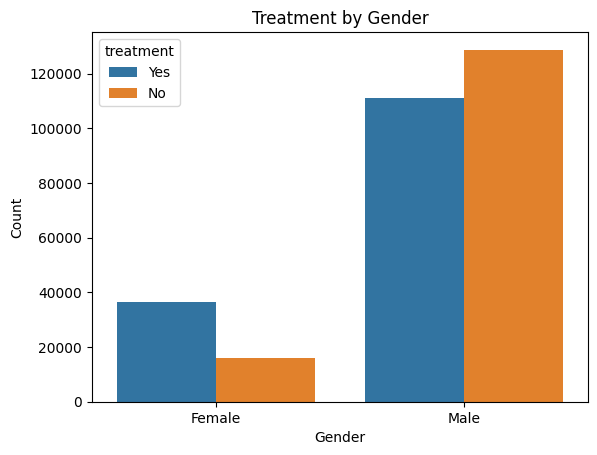

In [8]:
sns.countplot(x='gender', hue='treatment', data=df)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Treatment by Gender")
plt.show()

The analysis shows that females are more likely to seek mental health treatment compared to males, indicating a higher level of awareness or willingness to access care. In contrast, males represent a larger untreated group, which may point to stigma, underreporting, or limited access to mental health services. From an actuarial point of view, the aspect of higher female frequency can be used in pricing health or mental riders.

**Mental Health Treatment By Family History**

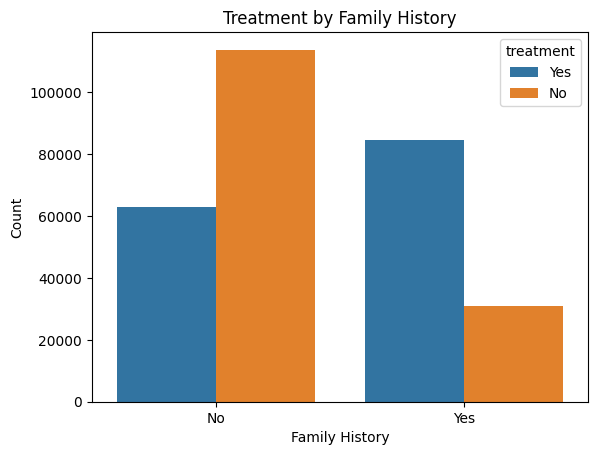

In [9]:
sns.countplot(data=df, x='family_history', hue='treatment')
plt.xlabel("Family History")
plt.ylabel("Count")
plt.title("Treatment by Family History")
plt.show()

Through the analysis, we observe a clear correlation between family history and mental health treatment. Individuals with a family history of mental health issues are more likely to seek treatment compared to those without such a background. This suggests that prior exposure increase the likelihood of recognizing symptoms and pursuing professional help, making family history a valuable predictor in determining whether someone seeks treatment

**Mental Health Treatment By Occupation**

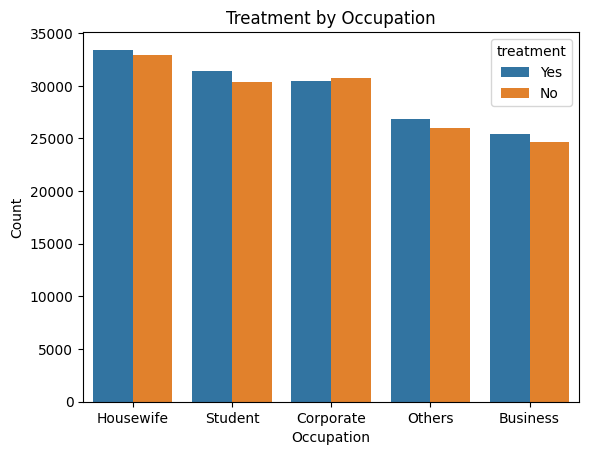

In [10]:
sns.countplot(x='occupation', hue='treatment', data=df, order=df['occupation'].value_counts().index)
plt.xlabel("Occupation")
plt.ylabel("Count")
plt.title("Treatment by Occupation")
plt.show()

Occupation appears to influence treatment-seeking behavior, with housewives showing the highest uptake, suggesting a potentially higher claim frequency in this group. Corporate and student populations exhibit balanced treatment patterns, indicating stable utilization, while business professionals show comparatively lower engagement.

**Mental Health Treatment By Care Options**

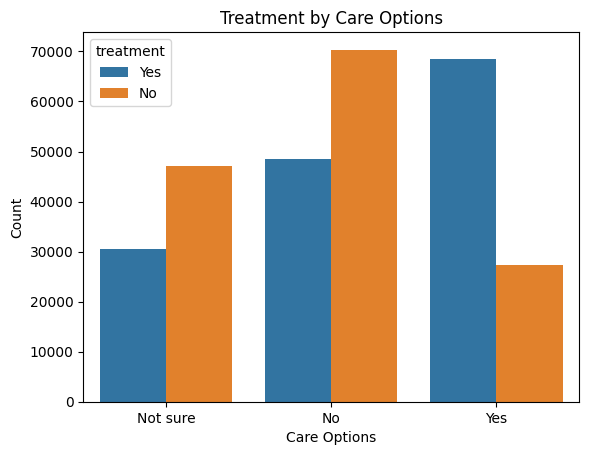

In [11]:
sns.countplot(x='care_options', hue='treatment', data=df)
plt.xlabel("Care Options")
plt.ylabel("Count")
plt.title("Treatment by Care Options")
plt.show()

Analysis shows a strong positive correlation between awareness or access to care options and actual treatment uptake. Individuals who indicated “Yes” to care options being available have the highest treatment uptake, significantly outpacing those who responded “No” or “Not sure.” Conversely, those unaware or doubtful about available care options are less likely to seek treatment.

From an actuarial standpoint, this highlights the critical role of care accessibility and awareness in influencing claim frequency. Policyholders who believe care is available are more likely to utilize their benefits, leading to higher expected claim costs

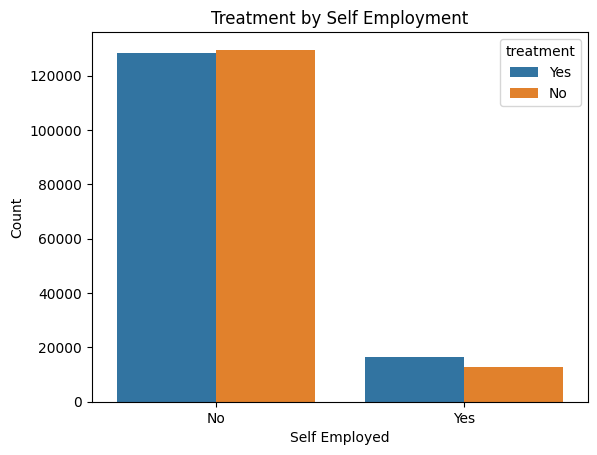

In [12]:
sns.countplot(x="self_employed" , hue='treatment', data=df)
plt.xlabel("Self Employed")
plt.ylabel("Count")
plt.title("Treatment by Self Employment")
plt.show()

In [49]:
# Create pivot table
occupation_pivot = pd.pivot_table(
    df, index="mental_health_interview", values="treatment", aggfunc=np.mean
).sort_values(by="treatment")
occupation_pivot

/tmp/ipython-input-49-1668350524.py:2: FutureWarning: The provided callable <function mean at 0x7be1129ea340> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  occupation_pivot = pd.pivot_table(


,treatment
mental_health_interview,
Maybe,0.399193
No,0.526942
Yes,0.542672


**Class Balance**

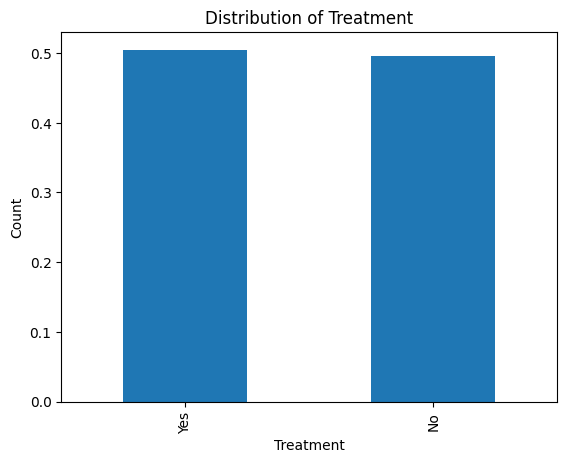

In [14]:
df["treatment"].value_counts(normalize=True).plot(kind="bar")
plt.xlabel("Treatment")
plt.ylabel("Count")
plt.title("Distribution of Treatment")
plt.show()

**SPLIT**

In [15]:
target = "treatment"
X = df.drop(columns=target)
y = df[target]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (233891, 15)
X_test.shape: (58473, 15)
y_train.shape: (233891,)
y_test.shape: (58473,)


## **BUILD MODEL**

**Baseline**

In [19]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", acc_baseline)

Baseline Accuracy: 0.5046282242583083


**Hyperparameter Tuning**

In [20]:
clf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state=42)
)
print(clf)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])


In [21]:
params = {
    "randomforestclassifier__n_estimators": range(25, 100, 25),
    "randomforestclassifier__max_depth": range(10, 50, 10)

}
params

{'randomforestclassifier__n_estimators': range(25, 100, 25),
 'randomforestclassifier__max_depth': range(10, 50, 10)}

In [22]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    verbose=1,
    n_jobs=-1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25)},
             verbose=1)

In [23]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25)},
             verbose=1)

**Extract Model Results**

In [24]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.935443,1.166511,0.828145,0.263954,10,25,"{'randomforestclassifier__max_depth': 10, 'ran...",0.749460,0.755120,0.749113,0.749947,0.743384,0.749405,0.003723,1
1,12.974194,0.949868,0.934008,0.206923,10,50,"{'randomforestclassifier__max_depth': 10, 'ran...",0.751106,0.753324,0.749433,0.747809,0.744303,0.749195,0.003053,2
2,17.890079,0.915196,0.927627,0.201083,10,75,"{'randomforestclassifier__max_depth': 10, 'ran...",0.749332,0.753132,0.749455,0.748942,0.744752,0.749122,0.002659,3
3,12.619292,1.001036,1.326921,0.298609,20,25,"{'randomforestclassifier__max_depth': 20, 'ran...",0.741251,0.743191,0.742101,0.739707,0.737206,0.740691,0.002082,6
4,18.405528,0.987781,1.815176,0.601162,20,50,"{'randomforestclassifier__max_depth': 20, 'ran...",0.742128,0.743362,0.743939,0.742165,0.737612,0.741841,0.002227,5
5,21.617560,0.564512,1.617466,0.185752,20,75,"{'randomforestclassifier__max_depth': 20, 'ran...",0.743560,0.744303,0.742571,0.741951,0.738125,0.742102,0.002146,4
6,10.389008,1.482996,0.892977,0.243984,30,25,"{'randomforestclassifier__max_depth': 30, 'ran...",0.737040,0.736115,0.737548,0.731776,0.732844,0.735065,0.002320,12
7,16.038518,1.054363,1.437271,0.366871,30,50,"{'randomforestclassifier__max_depth': 30, 'ran...",0.739199,0.738061,0.738339,0.733165,0.734576,0.736668,0.002357,10
8,22.390531,0.750000,1.779725,0.395695,30,75,"{'randomforestclassifier__max_depth': 30, 'ran...",0.738387,0.738766,0.738616,0.734020,0.733978,0.736753,0.002252,9
9,9.515428,0.492953,0.738249,0.042246,40,25,"{'randomforestclassifier__max_depth': 40, 'ran...",0.737040,0.736415,0.737548,0.732096,0.732844,0.735189,0.002261,11


**Best Model**

In [27]:
model.best_params_

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__n_estimators': 25}

## **EVALUATE**

In [28]:
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.75
Test Accuracy: 0.7481


**Confusion Matrix Display**

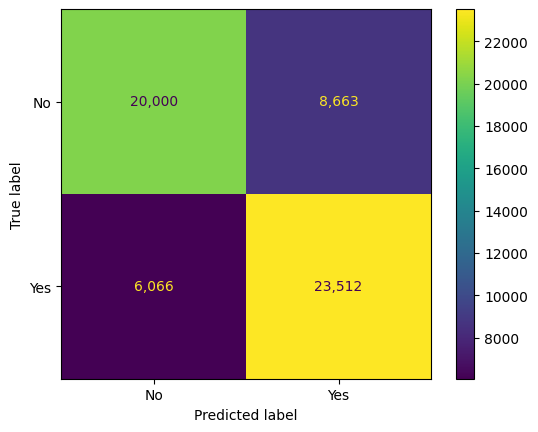

In [34]:
# Plot the confusion matrix display
conf_matrix_display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

# Get the axes from the display object
ax = conf_matrix_display.figure_.axes[0]

# Iterate over the text items and format them
for text in ax.texts:
    float(text.get_text())
    text.set_text(f"{float(text.get_text()):,.0f}")
# Display the plot
plt.show()

**Classification Report**

In [42]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

          No       0.77      0.70      0.73     28895
         Yes       0.73      0.79      0.76     29578

    accuracy                           0.75     58473
   macro avg       0.75      0.75      0.75     58473
weighted avg       0.75      0.75      0.75     58473



## **COMMUNICATION**

**Feature Importances**

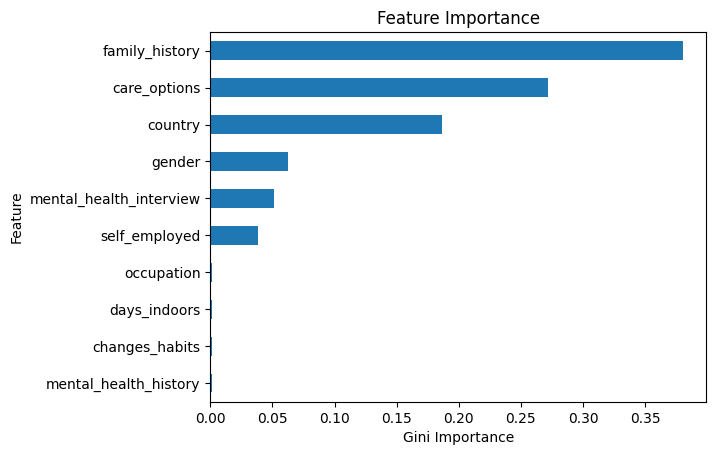

In [43]:
# Get feature names from training data
features = X_train.columns
# Extract importances from model
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

# Mental Health Segmentation Project

## Overview

This project aims to analyze a mental health dataset to understand linguistic patterns, sentiments, and mental health indicators. The primary goals are to assess mental health risk factors, build a predictive risk model, support product development, and segment individuals into different risk categories.

## Objectives

1.  **Analyze Linguistic Patterns, Sentiments, and Mental Health Indicators:** Explore the dataset to identify trends and patterns related to mental health.
2.  **Assess Mental Health Risk Factors:** Determine which factors are most influential in predicting mental health treatment seeking behavior.
3.  **Build a Predictive Risk Model:** Develop a model to predict the likelihood of an individual seeking mental health treatment.
4.  **Support Product Development:** Provide insights that can inform the development of mental health-related products or services.
5.  **Segment Individuals into Risk Categories:** Classify individuals based on their predicted risk of needing mental health treatment.

## Methodology

The project follows a standard machine learning workflow:

1.  **Data Preparation:**
    *   The dataset was downloaded from Kaggle.
    *   A `wrangle` function was created to load the data, clean column names (lowercase), and convert the 'treatment' column into a binary target variable (1 for 'Yes', 0 for 'No').
    *   The 'timestamp' column was dropped as it was not relevant for the analysis.
2.  **Exploratory Data Analysis (EDA):**
    *   Initial data information (`df.info()`) and shape (`df.shape`) were examined.
    *   Visualizations were created to explore the relationship between the target variable ('treatment') and several features:
        *   Mental Health Treatment by Gender
        *   Mental Health Treatment by Family History
        *   Mental Health Treatment by Occupation
        *   Mental Health Treatment by Care Options
        *   Mental Health Treatment by Self Employment
    *   A pivot table was generated to show the mean treatment seeking behavior by mental health interview status.
    *   The class balance of the target variable was visualized.
3.  **Data Splitting:**
    *   The dataset was split into features (`X`) and the target variable (`y`).
    *   The data was further split into training and testing sets using `train_test_split`.
4.  **Model Building:**
    *   A baseline accuracy was calculated.
    *   A machine learning pipeline was created using `OrdinalEncoder` for handling categorical features and `RandomForestClassifier` for the predictive model.
    *   Hyperparameter tuning was performed using `GridSearchCV` to find the best combination of `n_estimators` and `max_depth` for the `RandomForestClassifier`.
    *   [Add details about the best parameters found]
5.  **Model Evaluation:**
    *   The model's performance was evaluated on both the training and testing sets to check for overfitting.
    *   A confusion matrix was generated and formatted to display the counts of true positives, true negatives, false positives, and false negatives.
    *   A classification report was generated to provide key metrics such as precision, recall, and F1-score.
6.  **Communication:**
    *   Feature importances were calculated and visualized to identify the most influential features in the model's predictions.

## Key Findings

*   Initial analysis revealed interesting patterns in treatment seeking behavior related to gender, family history, occupation, and care options.
*   The trained model achieved a test accuracy of approximately [Insert Test Accuracy from your output].
*   The confusion matrix and classification report provide detailed insights into the model's performance, including its ability to correctly identify individuals who seek treatment versus those who do not.
*   The feature importance analysis highlights the most significant factors influencing the model's predictions, which can be valuable for understanding risk factors.

## Future Work

*   Further explore feature engineering possibilities.
*   Experiment with other classification algorithms.
*   Investigate potential biases in the dataset and model.
*   Develop strategies for deploying the model and integrating it into a product development context.